# Topobathy Data Interpolation 

In [1]:
import geopandas as gpd
import shapely
from pygeohydro import EHydro

import curviriver as cr

We demonstrate capabilities of CurviRiver by generating a curvilinear mesh along a portion of the Columbia River and regridding [eHydro](https://www.sam.usace.army.mil/Missions/Spatial-Data-Branch/eHYDRO/) topobathy data on to the mesh.

First, we use [PyGeoHydro](https://docs.hyriver.io/readme/pygeohydro.html) to retrieve eHydro data for a part of the Columbia River that topobathy data are available. We get both the survey outline and the bathymetry data.

In [2]:
ehydro = EHydro("outlines")
geom = ehydro.survey_grid.loc[ehydro.survey_grid["OBJECTID"] == 210, "geometry"].iloc[0]
outline = ehydro.bygeom(geom, ehydro.survey_grid.crs)
ehydro = EHydro("points")
cloud = ehydro.bygeom(geom, ehydro.survey_grid.crs)

Now, we use the survey outline polygon to generate a curvilinear mesh. We use the `poly_segmentize` function for this purpose that has two parameters: Spacing in streamwise direction and number of points in cross-stream direction. The function returns a `geopandas.GeoSeries` of the cross-sections, vertices of which are the mesh points. For plotting purposes, we generate the full mesh edges.

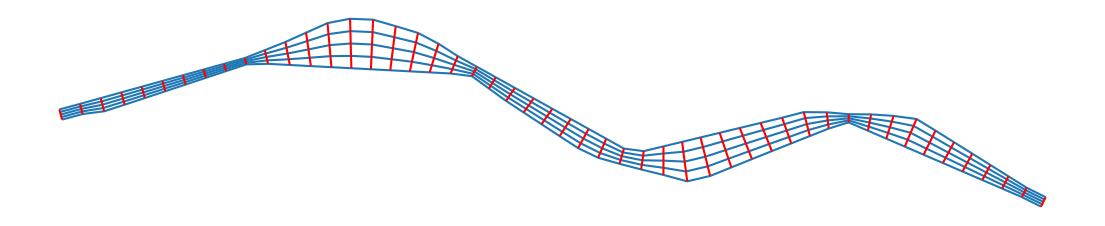

In [3]:
poly = outline.convex_hull.unary_union
spacing_streamwise = 2000
xs_npts = 5
stream = cr.poly_segmentize(poly, outline.crs, spacing_streamwise, xs_npts)
transect = gpd.GeoSeries(
    [
        shapely.LineString(stream.get_coordinates(index_parts=True).swaplevel().loc[i, :])
        for i in range(xs_npts)
    ],
    crs=stream.crs,
)
ax = transect.plot(figsize=(14, 14))
stream.plot(ax=ax, color="r")
ax.set_axis_off()
ax.figure.savefig("../_static/curvilinear.png", bbox_inches="tight", dpi=300)

Let's make the mesh more dense for resampling the point cloud data from eHydro onto the generated grid using the `idw_line_interpolation` function which implements the Inverse Distance Weighting (IDW) method.

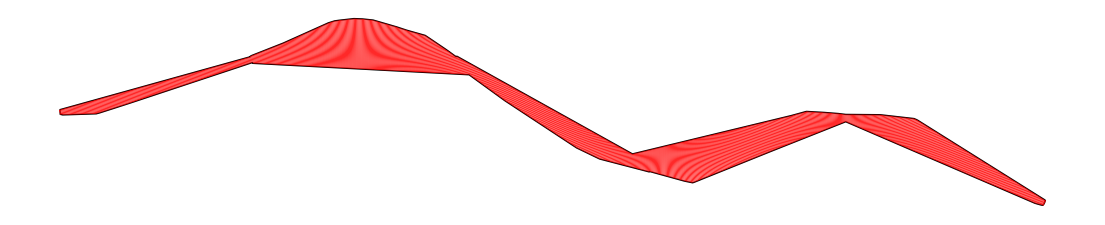

In [4]:
poly = outline.convex_hull.unary_union
spacing_streamwise = 100
xs_npts = 50
stream = cr.poly_segmentize(poly, outline.crs, spacing_streamwise, xs_npts)
xs_cloud = cr.idw_line_interpolation(
    cloud, stream, "Z_use", grid_points=True, search_radius_coeff=0.5
)
ax = gpd.GeoSeries([poly]).plot(facecolor="none", edgecolor=["k", "r"], figsize=(14, 14))
stream.plot(ax=ax, color="r", linewidth=0.6)
ax.set_axis_off()

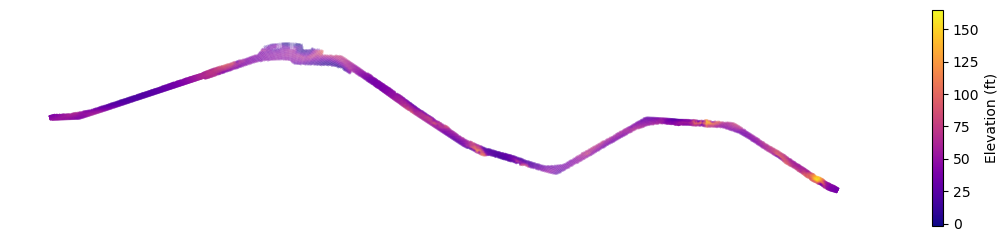

In [5]:
xs_cloud = cr.idw_line_interpolation(
    cloud, stream, "Z_use", grid_points=True, search_radius_coeff=3
)

vmin, vmax = xs_cloud.Z_use.min(), xs_cloud.Z_use.max()
ax = xs_cloud.plot(
    column="Z_use",
    cmap="plasma",
    vmin=vmin,
    vmax=vmax,
    markersize=0.01,
    legend=True,
    legend_kwds={"label": "Elevation (ft)", "shrink": 0.2},
    figsize=(14, 14),
)
ax.set_axis_off()

By comparing the plot of eHydro's point cloud data with our interpolation, we can see that the results correctly set NaN values for points that on the mesh, but there is no data for them in the point cloud.

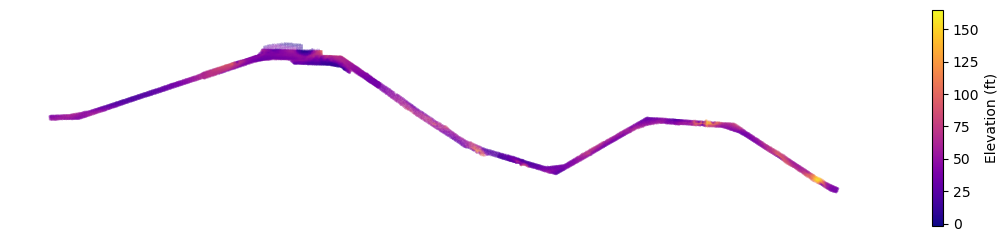

In [6]:
ax = cloud.plot(
    column="Z_use",
    cmap="plasma",
    vmin=vmin,
    vmax=vmax,
    markersize=0.01,
    legend=True,
    legend_kwds={"label": "Elevation (ft)", "shrink": 0.2},
    figsize=(14, 14),
)
ax.set_axis_off()